In [1]:
from typing import Union

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.optim.lr_scheduler as lr_scheduler
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.decomposition

from lib.data_preprocessing import remove_correlated_columns, normalize_data
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data, flatten
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.ds.challenge_dataset import load_challenge_data
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.attention_classifier_training import train_attention_classifier_with_cv, train_attention_classifier, evaluate_attention_classifier
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.ds.numpy_dataset import NumpyDataset
from lib.model.model_persistence import save_model, load_model
from lib.random import set_random_seed
from lib.metrics import calculate_average_metrics_for_final_epoch_of_folds, calculate_average_metrics_per_epoch, calculate_average_metrics
from lib.ds.bird_combiner import combine_birds
from lib.challenge import predict_for_challenge, save_results_to_csv, load_results_from_csv
from lib.label_fixing import fix_labels_information_gain
from lib.binary_classification import to_binary
import lib.torch_device as tdev

%load_ext autoreload
%autoreload 2

In [2]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [3]:
data_raw, labels = load_all_data('dataset')
print(f'{data_raw.shape = }')
print(f'{labels.shape   = }')

data_raw.shape = (1200, 100, 548)
labels.shape   = (1200, 100)


In [4]:
combined_ds = combine_birds(
    NumpyDataset(data_raw, labels), 
    sequence_length=300,
    random_seed=42
)
print(f'{combined_ds.data.shape = }')
print(f'{combined_ds.labels.shape = }')

Creating random sequence from 1 duplicates: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120000/120000 [01:54<00:00, 1048.68it/s]

combined_ds.data.shape = (400, 300, 548)
combined_ds.labels.shape = (400, 300)


In [6]:
combined_binary_labels = to_binary(
    labels=combined_ds.labels, 
    pos_labels=np.array(range(1, 7)),
    neg_labels=np.array([0]),
)
print(combined_binary_labels)

combined_binary_ds = combined_ds.copy()
combined_binary_ds.labels = combined_binary_labels

[[0 1 0 ... 0 0 0]
 [0 1 0 ... 1 0 1]
 [0 0 0 ... 1 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 1 1 0]
 [1 1 0 ... 1 0 0]]


# Hyper Parameters

In [7]:
hyper_parameters = AttentionClassifierHyperParameters(
    in_features=data_raw.shape[-1],
    out_features=2,
    
    attention_window_size=30,
    d_model=60,
    num_heads=12,
    attention_stack_size=0,
    attention_stack_activation_provider=lambda: nn.LeakyReLU(),
    attention_dropout=0.45,
    
    in_linear_hidden_out_features=[60, 60],
    out_linear_hidden_out_features=[24, 16],
    linear_activation_provider=lambda: nn.LeakyReLU(),
    linear_dropout=0.45,
)

In [8]:
def create_training_hyper_parameters(
    num_epochs: Union[int, float], 
    initial_lr: float,
    lr_scheduler_milestones: list[Union[int, float]],
    lr_scheduler_gamma: float
):
    return TrainingHyperParameters(
        batch_size=32,
        
        loss_weight_factors=None,
        
        optimizer_provider=lambda model, lr: optim.Adamax(
            model.parameters(),
            lr=lr,
            betas=(0.9, 0.98),
            eps=1e-9
        ),

        num_epochs=int(num_epochs),
        
        lr=initial_lr,
        lr_scheduler_milestones=[int(m) for m in lr_scheduler_milestones],
        lr_scheduler_gamma=lr_scheduler_gamma,
        lr_scheduler_provider=lambda optimizer, milestones, gamma: lr_scheduler.MultiStepLR(
            optimizer, 
            milestones=milestones,
            gamma=gamma
        )
    )

# Training

## Cross Validation

Creating 8 folds


CV Folds:   0%|                                                                                                                                                                                                                                 | 0/8 [00:00<?, ?it/s]

Executing CV for fold 0
Training fold 0
#### Training AttentionClassifier ####
###################
AttentionClassifier with 42158 parameters, in_fnn: 40260, attention_stack: 0, out_fnn: 1898
###################
train label counts = [74723, 30277]
loss weights = [1.0, 2.47]
eval label counts = [10635, 4365]
eval loss weights = [1.0, 2.44]
Training Epoch   1/300: lr = 1.00E-04, epoch =     1, avg_loss = 0.000073, num_samples = 105000, num_correct = 44398, acc = 0.422838, bacc = 0.494365
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000097, num_samples = 15000, num_correct =  4368, acc = 0.291200, bacc = 0.500141
Training Epoch   2/300: lr = 1.00E-04, epoch =     2, avg_loss = 0.000073, num_samples = 105000, num_correct = 30295, acc = 0.288524, bacc = 0.500120
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000096, num_samples = 15000, num_correct =  4370, acc = 0.291333, bacc = 0.500235
Training Epoch   3/300: lr = 1.00E-04, epoch =     3, avg_loss = 0.000072, num_samples =

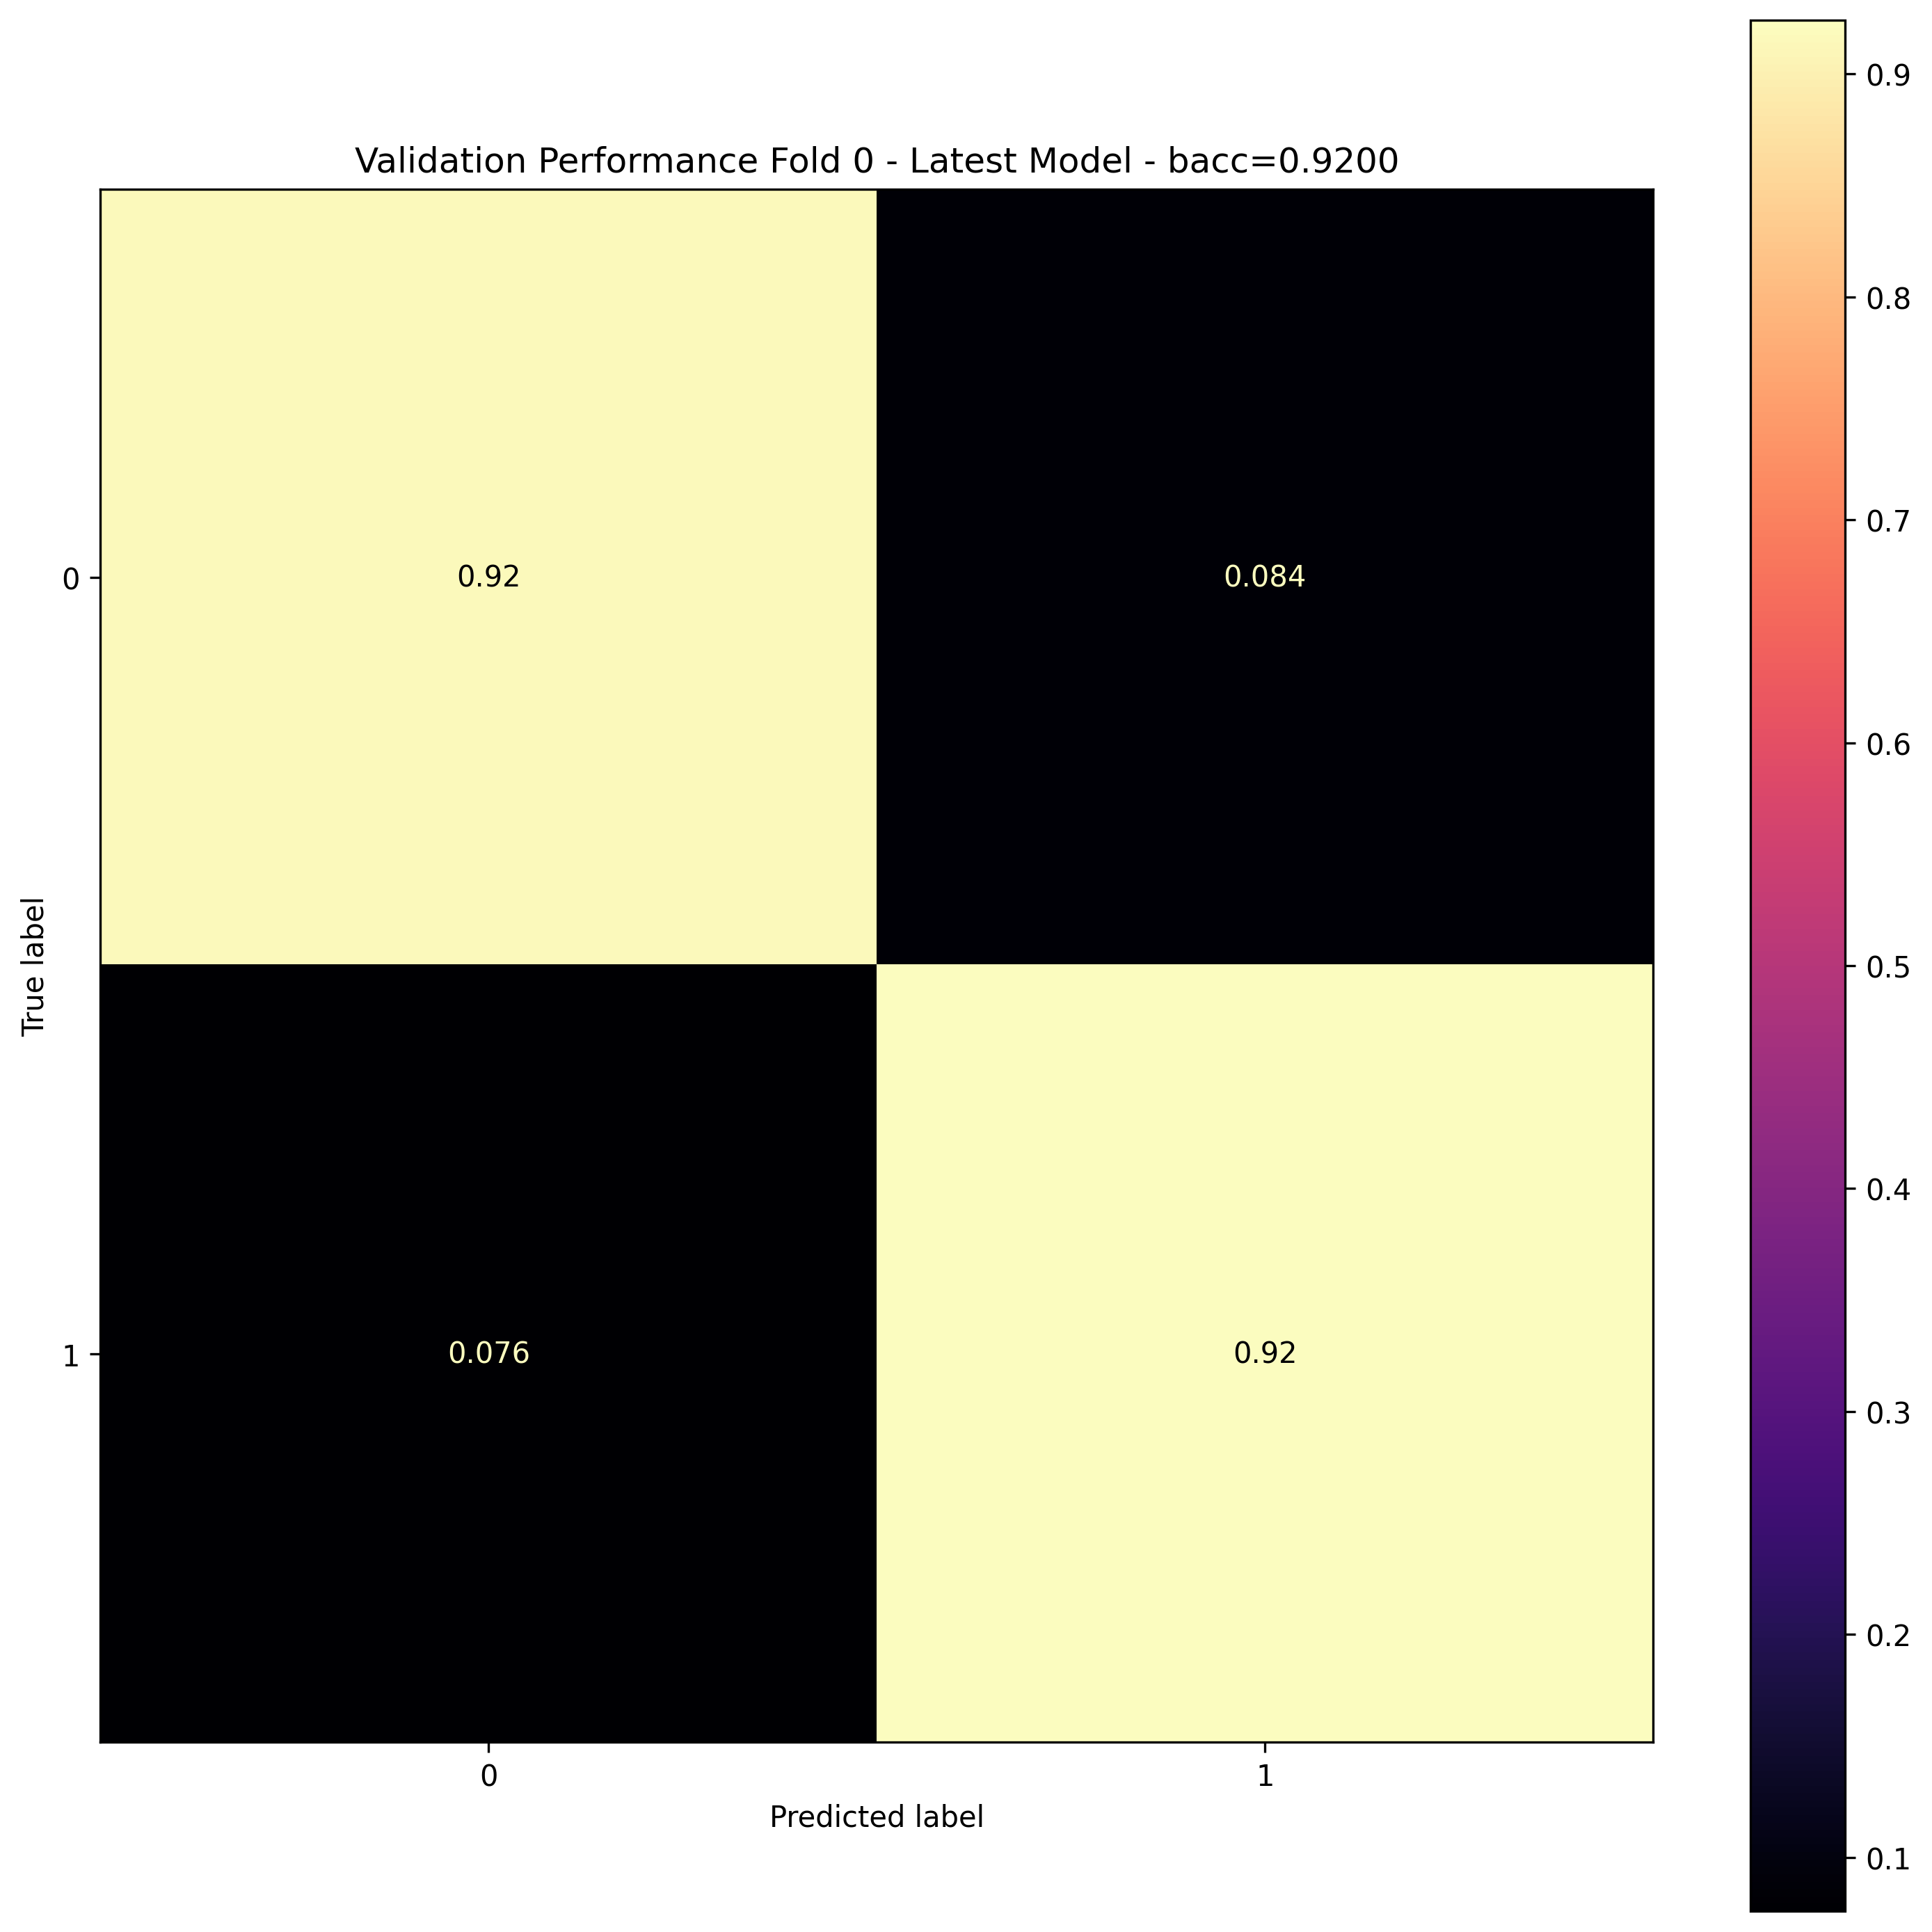

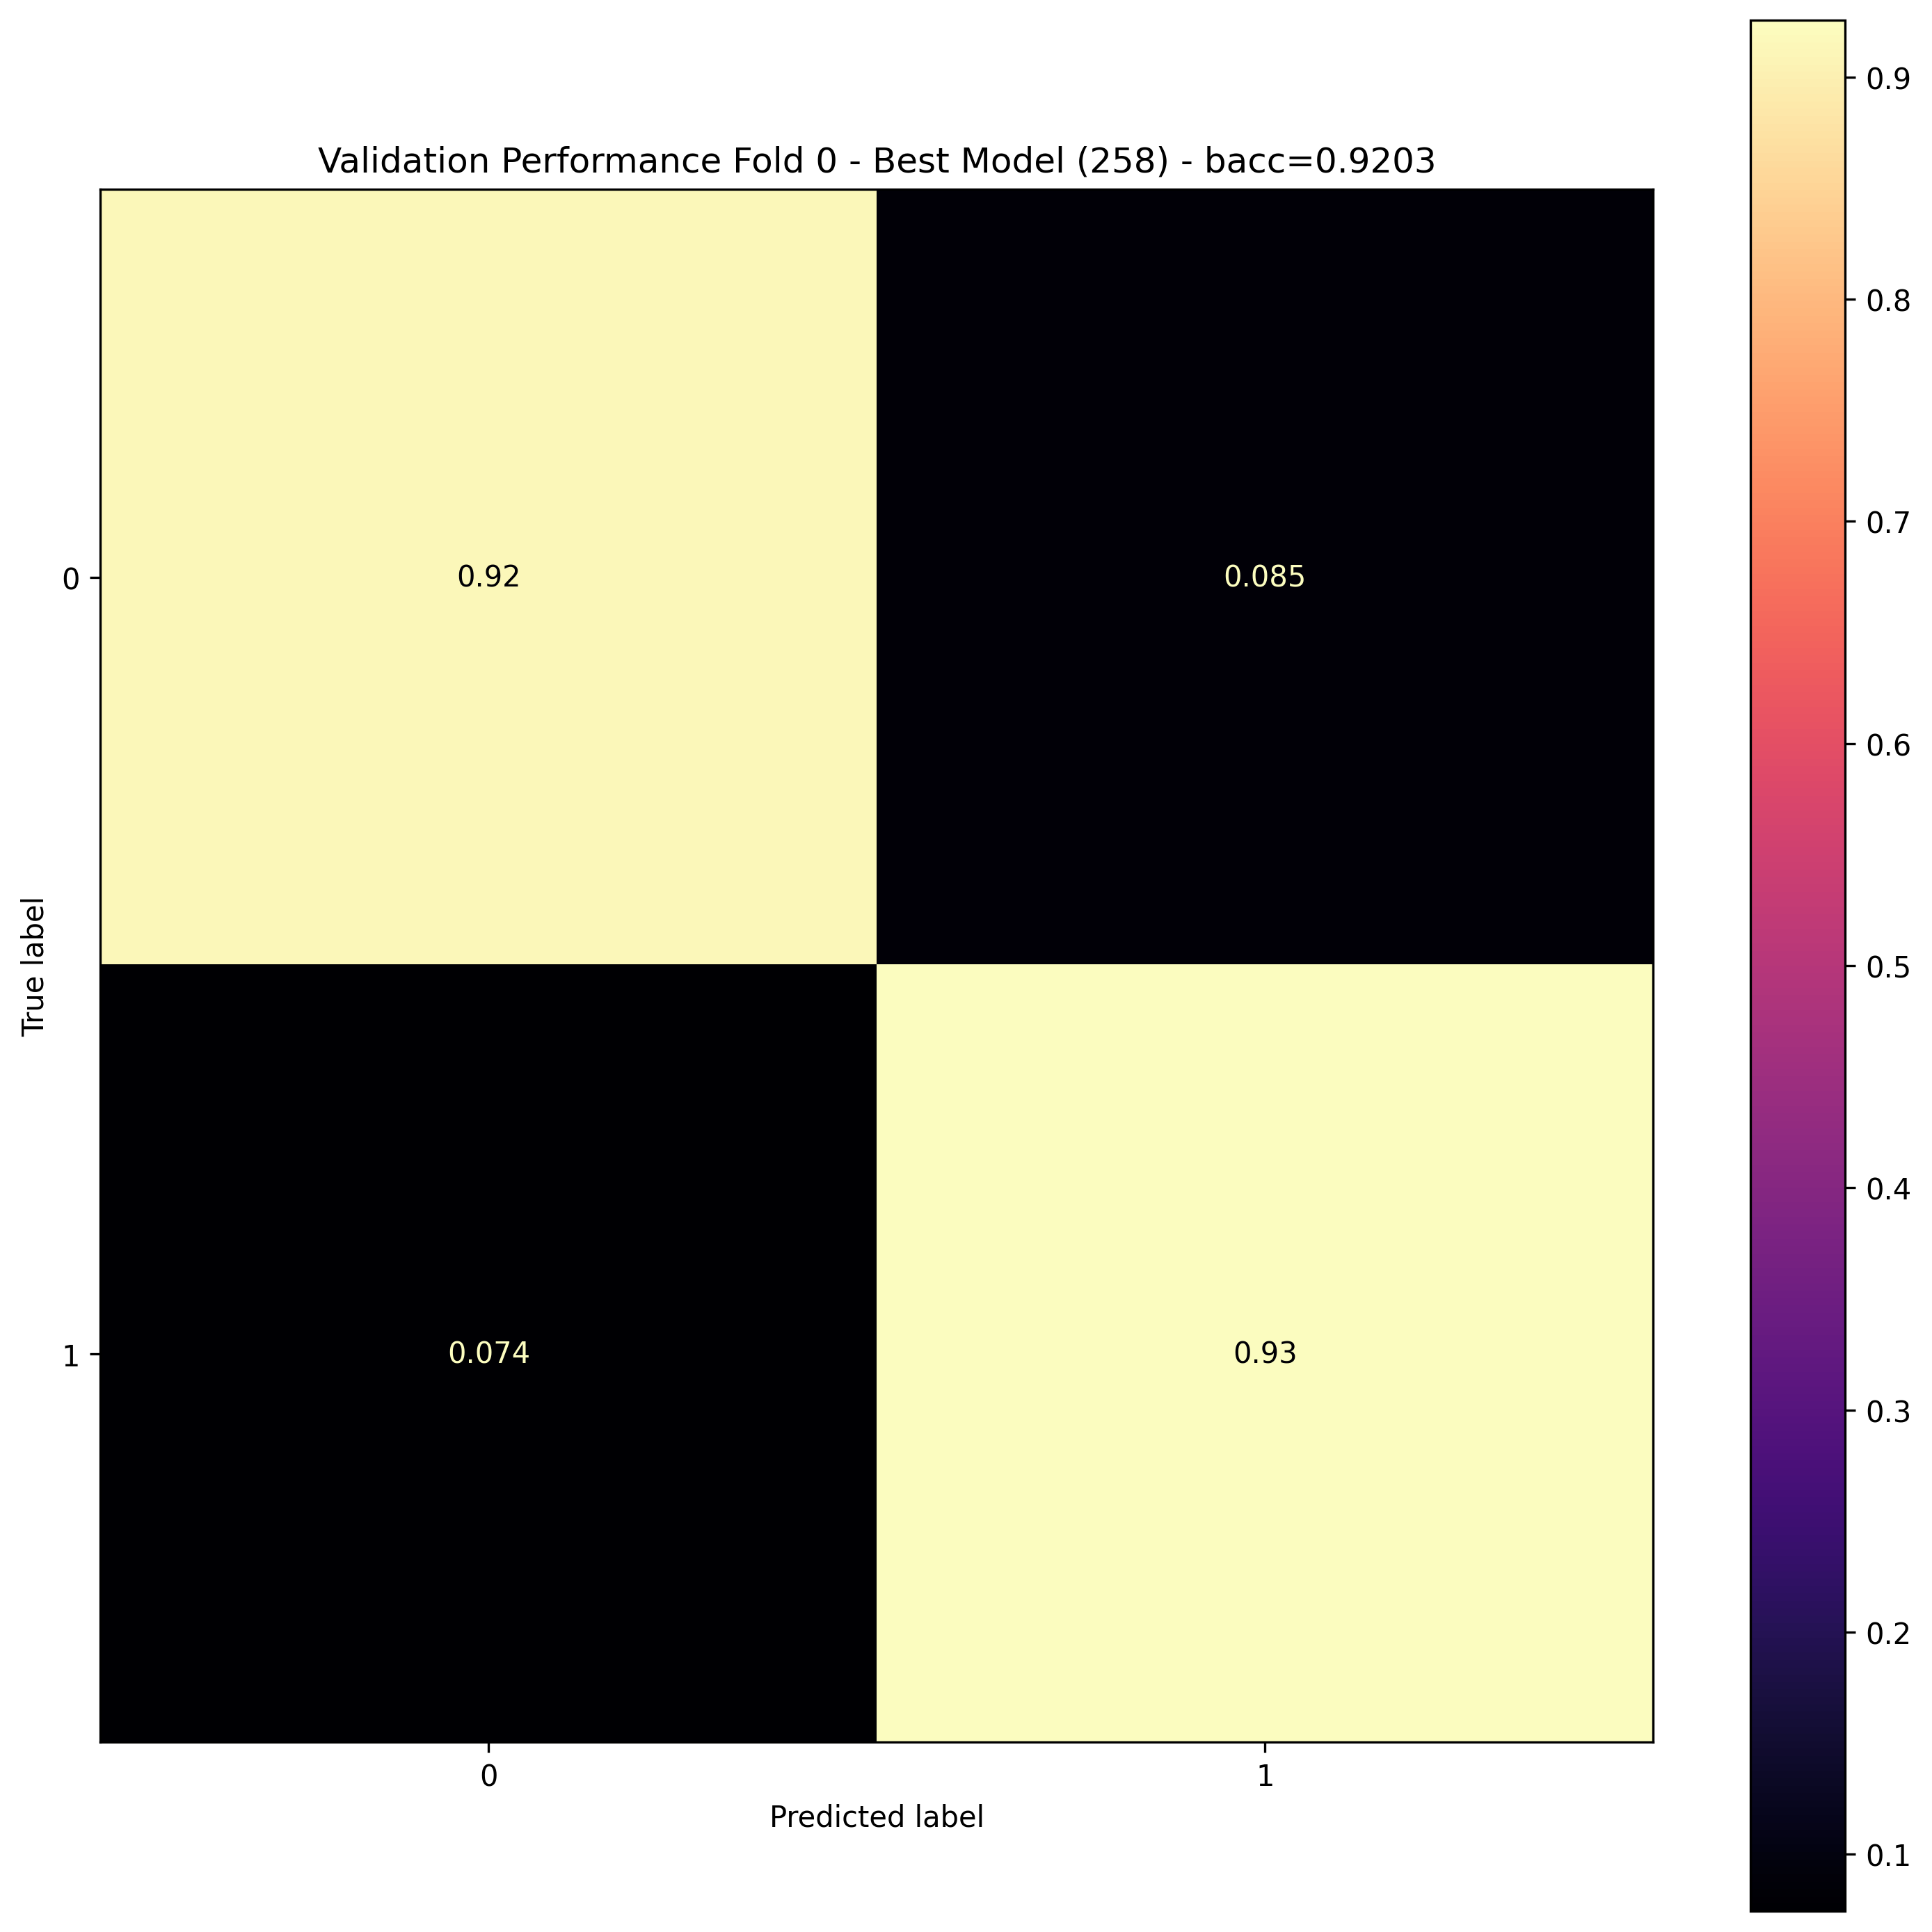

CV Folds:  12%|███████████████████████████▏                                                                                                                                                                                             | 1/8 [00:59<06:56, 59.50s/it]

Saved model with scaler as "bird_no_bird_classifier cv2023-06-06_22.49 fold-0-best train-bacc=0.9349 eval-bacc=0.9203"
Executing CV for fold 1
Training fold 1
#### Training AttentionClassifier ####
###################
AttentionClassifier with 42158 parameters, in_fnn: 40260, attention_stack: 0, out_fnn: 1898
###################
train label counts = [74588, 30412]
loss weights = [1.0, 2.45]
eval label counts = [10770, 4230]
eval loss weights = [1.0, 2.55]
Training Epoch   1/300: lr = 1.00E-04, epoch =     1, avg_loss = 0.000073, num_samples = 105000, num_correct = 41139, acc = 0.391800, bacc = 0.501799
Evaluation Epoch   1/300: epoch =     1, avg_loss = 0.000094, num_samples = 15000, num_correct =  6280, acc = 0.418667, bacc = 0.545358
Training Epoch   2/300: lr = 1.00E-04, epoch =     2, avg_loss = 0.000072, num_samples = 105000, num_correct = 47142, acc = 0.448971, bacc = 0.562382
Evaluation Epoch   2/300: epoch =     2, avg_loss = 0.000093, num_samples = 15000, num_correct =  6951, a

CV Folds:  12%|███████████████████████████▏                                                                                                                                                                                             | 1/8 [01:39<11:39, 99.98s/it]

Training Epoch 210/300: lr = 5.63E-05, epoch =   210, avg_loss = 0.000018, num_samples = 105000, num_correct = 97600, acc = 0.929524, bacc = 0.933217
Evaluation Epoch 210/300: epoch =   210, avg_loss = 0.000027, num_samples = 15000, num_correct = 13765, acc = 0.917667, bacc = 0.916466


KeyboardInterrupt: 

In [9]:
set_random_seed(43)

cv_training_hyper_parameters = create_training_hyper_parameters(
    num_epochs=300,
    initial_lr=1e-4,
    lr_scheduler_milestones=[30, 100, 250],
    lr_scheduler_gamma=0.75,
)

cv_models_with_scalers, cv_folds_metrics, best_models_metrics = train_attention_classifier_with_cv(
    hyper_parameters, 
    cv_training_hyper_parameters, 
    combined_binary_ds,
    n_folds=8,
    device=device,
    save_models='best',
    model_saving_name='bird_no_bird_classifier',
)


## Metrics ##
print(
'''

#################
#### Metrics ####
#################

'''
)

cv_average_best_best_models_eval_metrics = calculate_average_metrics([m[1] for m in best_models_metrics])
print(f'{cv_average_best_best_models_eval_metrics = } \n\n')

cv_final_epoch_avg_train_metrics, cv_final_epoch_avg_eval_metrics = calculate_average_metrics_for_final_epoch_of_folds(cv_folds_metrics)
print(f'{cv_final_epoch_avg_train_metrics = }')
print(f'{cv_final_epoch_avg_eval_metrics  = }')

cv_avg_epoch_train_metrics = calculate_average_metrics_per_epoch(cv_folds_metrics)

rows = []
for fold_nr, fold_metrics in enumerate(cv_folds_metrics):
    for epoch_nr, (train_metrics, eval_metrics) in enumerate(fold_metrics):
        rows.append({
            'cv_fold': fold_nr,
            'epoch': epoch_nr,
            'type': 'CV Train BACC',
            'bacc': train_metrics.bacc,
        })
        if eval_metrics is not None:
            rows.append({
                'cv_fold': fold_nr,
                'epoch': epoch_nr,
                'type': 'CV Eval BACC',
                'bacc': eval_metrics.bacc,
            })

cv_metrics_df = pd.DataFrame(rows)

# Plots

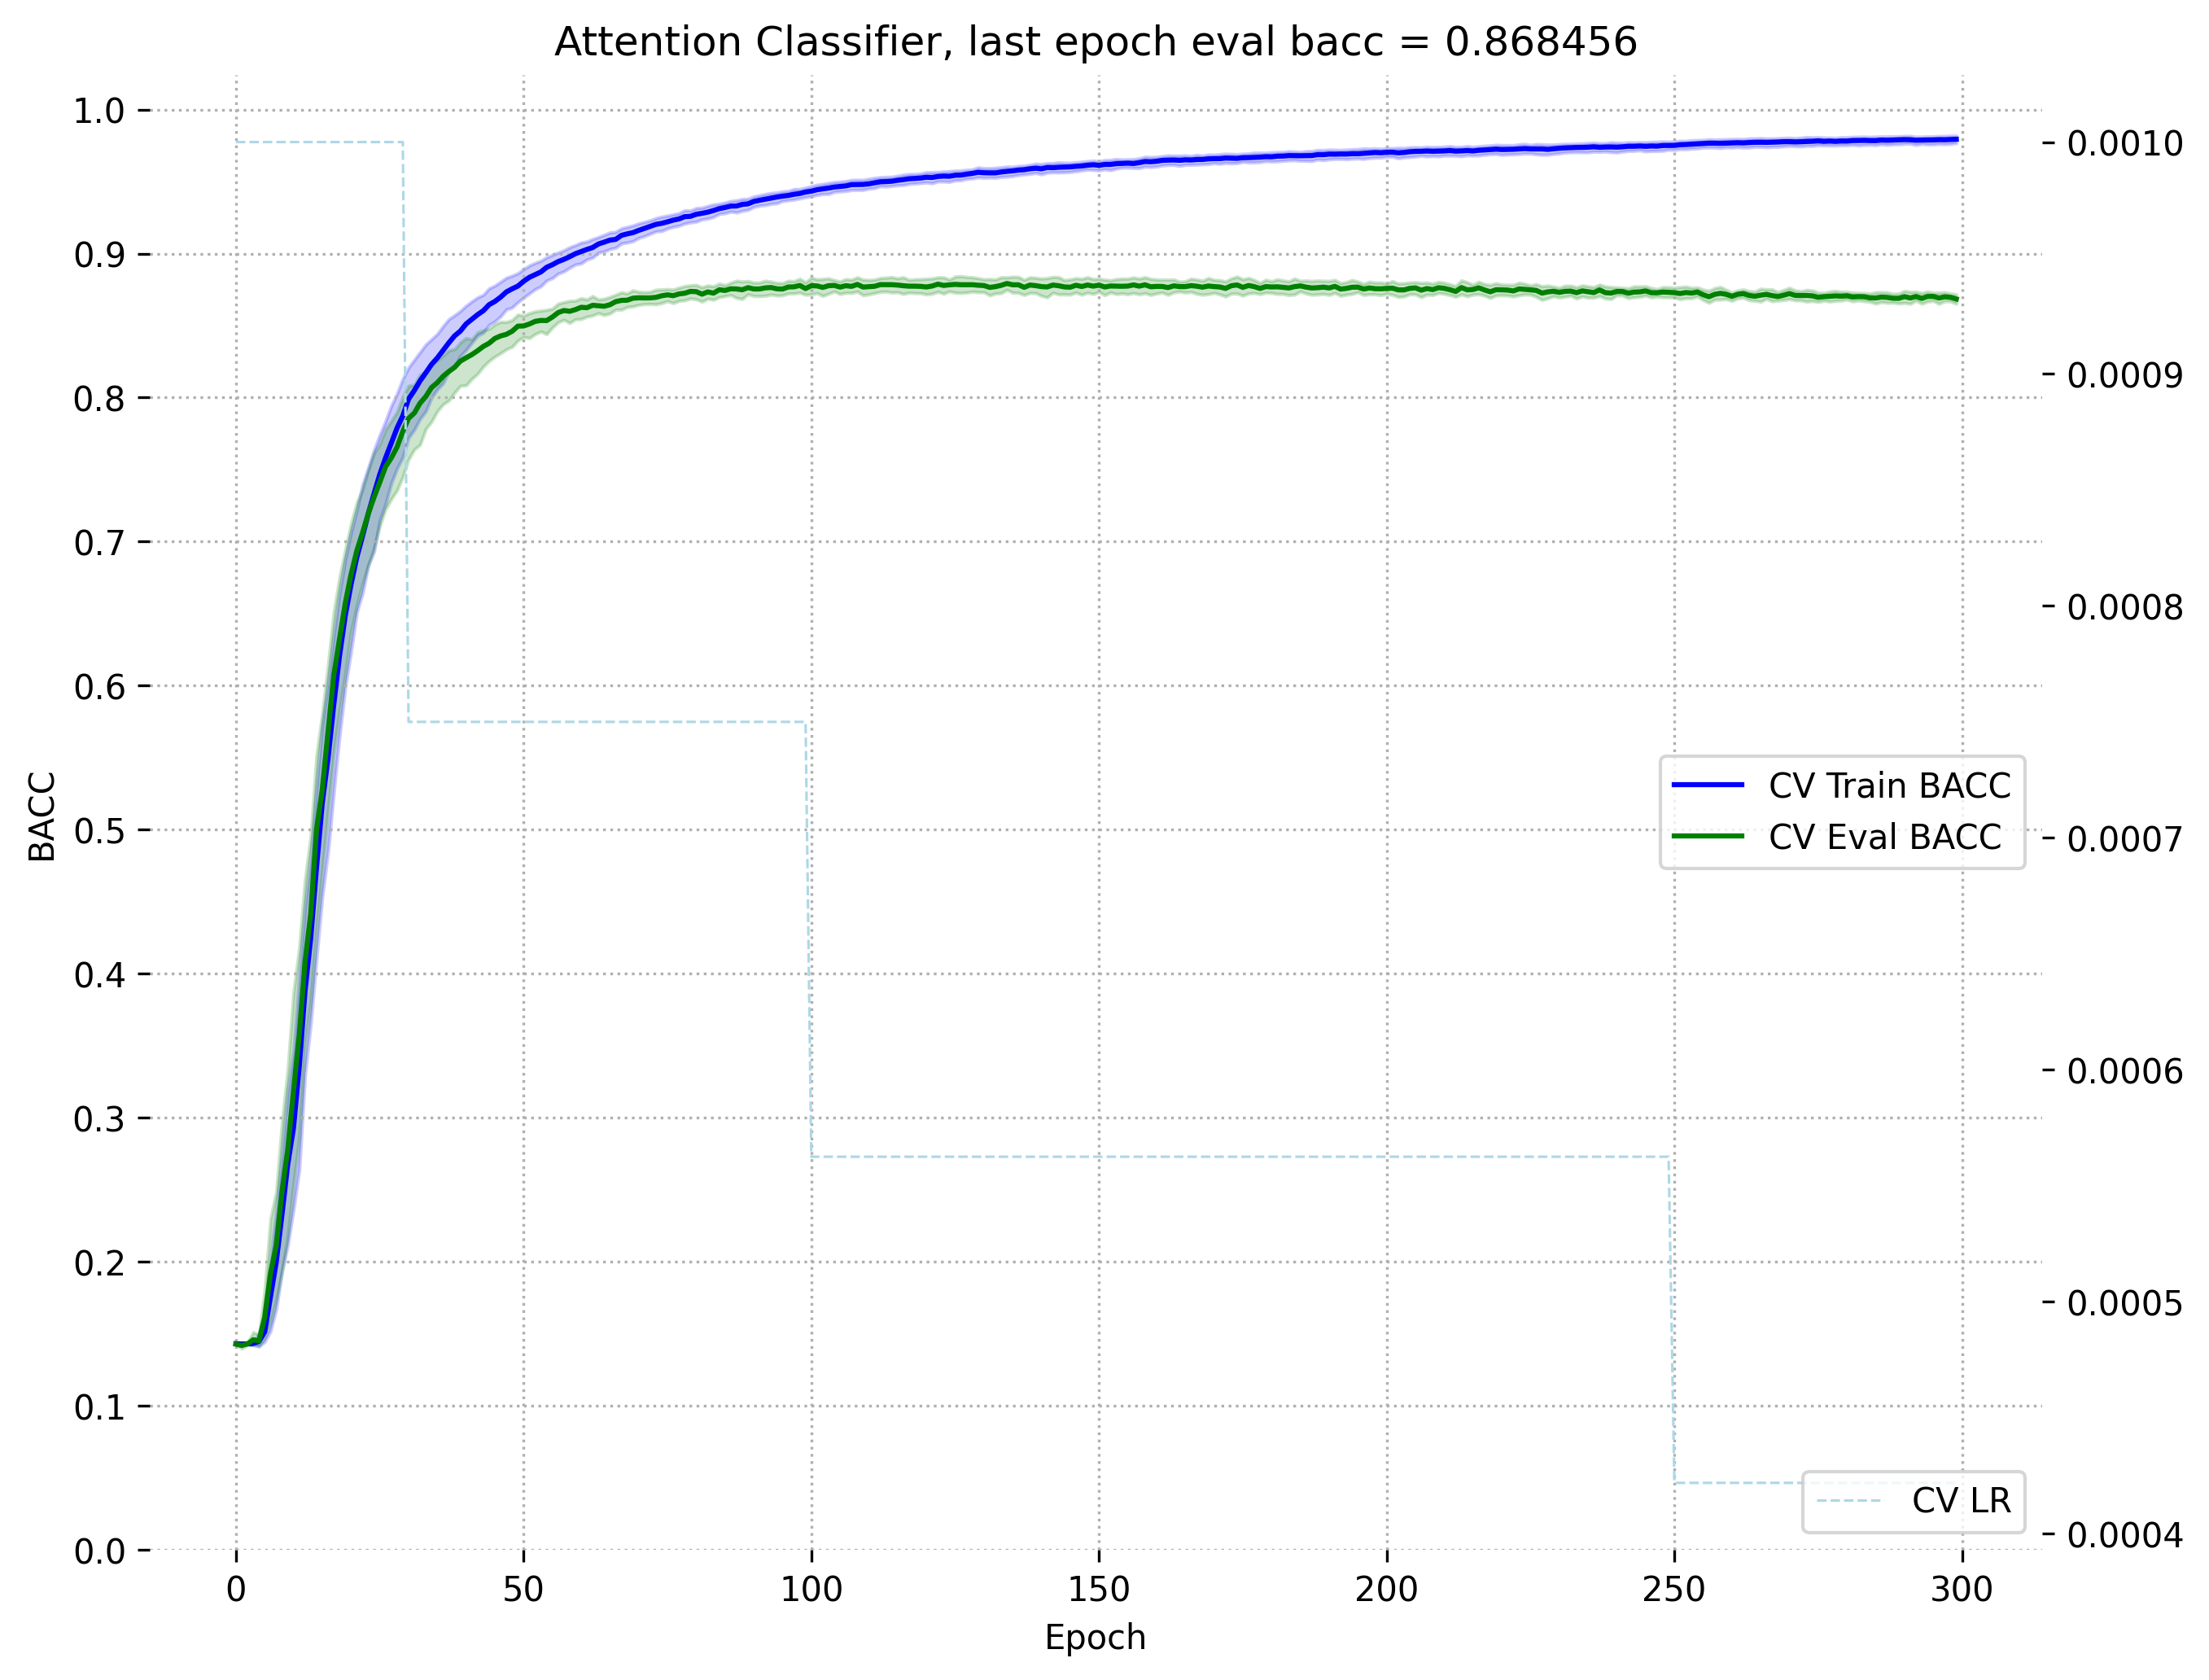

In [25]:
def create_lrs_over_epochs(training_hyper_parameters: TrainingHyperParameters) -> list[float]:
    lrs: list[float] = []
    
    lr = training_hyper_parameters.lr
    for epoch_nr in range(training_hyper_parameters.num_epochs):
        if epoch_nr in training_hyper_parameters.lr_scheduler_milestones:
            lr *= training_hyper_parameters.lr_scheduler_gamma
        lrs.append(lr)
    return lrs
    

def plot_baccs_over_epochs(title: str):
    fig, ax = plt.subplots(1, 1, figsize=(10, 8), dpi=300)
    
    cv_epoch_range = np.arange(0, cv_training_hyper_parameters.num_epochs)
    
    sns.lineplot(data=cv_metrics_df, x='epoch', y='bacc', hue='type', ax=ax, palette=['blue', 'green'])
    
    twin_ax = ax.twinx()
    lr_plots_kwargs = {
        'ls': '--',
        'lw': 0.75
    }
    twin_ax.plot(cv_epoch_range, create_lrs_over_epochs(cv_training_hyper_parameters), label='CV LR', c='lightblue', **lr_plots_kwargs)

    ax.set(
        title=title,
        xlabel='Epoch',
        ylabel='BACC',
        yticks=[x * 0.1 for x in range(11)]
    )

    ax.grid(ls=':')
    ax.legend(loc='center right')
    twin_ax.legend(loc='lower right')

    for spine in ['top', 'right', 'bottom', 'left']:
        ax.spines[spine].set_visible(False)
        twin_ax.spines[spine].set_visible(False)

    plt.show()

average_last_epoch_eval_bacc = cv_metrics_df.query('type == "CV Eval BACC"').groupby('epoch').mean().iloc[-1]['bacc']
plot_baccs_over_epochs(f'Attention Classifier, last epoch eval bacc = {average_last_epoch_eval_bacc:6f}')